# TMP notebook
competition : RSNA Screening Mammography Breast Cancer Detection  
url : https://www.kaggle.com/competitions/rsna-breast-cancer-detection

# 2023/1/22
テーブルデータのみのlightgbmでどれくらい精度出るか検証  
* 交差検証なし、パラメータチューニングなし

## 結果
* LB - 0.04

In [ ]:
# import pandas as pd
# import lightgbm as lgb
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# import warnings
# warnings.simplefilter('ignore')

# def pre_view(df):
#     if 'view' in df.columns.tolist():
#         df['view'] = df['view'].apply(lambda x: x if x=='CC' or x=='MLO' else 'others')
#     else:
#         pass
#     return df

# train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
# test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
# submit = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')

# column = ['laterality', 'view', 'age', 'implant', 'cancer']
# new_train = train[column]
# new_train = new_train.dropna()
# new_train = pre_view(new_train)
# new_train_dum = pd.get_dummies(new_train)
# train_cancer = new_train_dum[new_train_dum.cancer==1]
# train_no_cancer = new_train_dum[new_train_dum.cancer==0]
# tmp = train_no_cancer.sample(n=1158, random_state=0)
# concat_train = pd.concat([train_cancer, tmp])

# concat_train = concat_train.reset_index()
# X = concat_train.drop(columns=['cancer'])
# y = concat_train[['cancer']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
# # X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0, stratify=y_test)

# model = lgb.LGBMClassifier(random_state=0)
# model.fit(X_train, y_train)
# pred = model.predict(X_test)
# print(f1_score(y_test, pred))

# tmp = test[['laterality', 'view', 'age', 'implant']]
# tmp = pre_view(tmp)
# tmp_ = pd.concat([new_train, tmp])
# tmp_dum = pd.get_dummies(tmp_)
# tmp_dum = tmp_dum.reset_index()
# test_X = tmp_dum.iloc[new_train.shape[0]:]
# test_X = test_X.drop(columns=['cancer'])
# test_pred = model.predict(test_X)
# print(test_pred)
# test_copy = test.copy()
# test_copy['pred'] = test_pred
# tmp = test_copy.groupby('prediction_id')['pred'].mean()
# sub = pd.DataFrame(data={'prediction_id': tmp.index.tolist(), 'cancer': tmp.values.tolist()})
# display(sub)
# sub.to_csv('submission.csv', index=None)

# 2023/1/28
画像について調べる

In [3]:
!pip install -qU python-gdcm pydicom pylibjpeg
!pip install japanize-matplotlib

import os
import copy
import random
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

ERROR: Could not find a version that satisfies the requirement python-gdcm (from versions: none)
ERROR: No matching distribution found for python-gdcm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.4 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=deaf68a37e20cf6b91e023b4f2dadb842d9e6173085ff7fc3453f01467e7b6c5
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [5]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
dicom_df = pd.read_csv('/kaggle/input/rsna-dicom-csv/dicom.csv')

In [26]:
dicom_df.PhotometricInterpretation.value_counts()

MONOCHROME2    45369
MONOCHROME1     9337
Name: PhotometricInterpretation, dtype: int64

In [10]:
dicom_df.isnull().sum()

Unnamed: 0                            0
patient_id                            0
image_id                              0
PixelIntensityRelationship            5
ExposureControlMode               25806
WindowCenter                          0
WindowWidth                           0
LossyImageCompression                 5
ContentDate                           0
Rows                                  0
RescaleSlope                          5
PixelSpacing                      20485
SeriesInstanceUID                     0
ContentTime                           0
BodyPartThickness                 25907
HighBit                               0
PixelPaddingValue                  3123
ExposureControlModeDescription    25806
BitsStored                            0
RescaleType                           5
BitsAllocated                         0
InstanceNumber                        0
RescaleIntercept                      5
StudyInstanceUID                      0
PartialView                       38224


Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10011.1.1031443799
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10011.1.1031443799
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183903.573986'
(0010, 0020) Patient ID                          LO: '10011'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10011
(0020, 000e) Series Instance

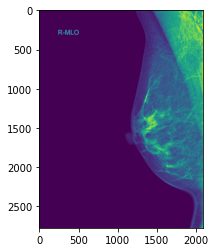

In [8]:
sample_image = '/kaggle/input/rsna-breast-cancer-detection/train_images/10011/1031443799.dcm'
im_data = pydicom.dcmread(sample_image)
print(im_data)
plt.imshow(im_data.pixel_array)
plt.show()

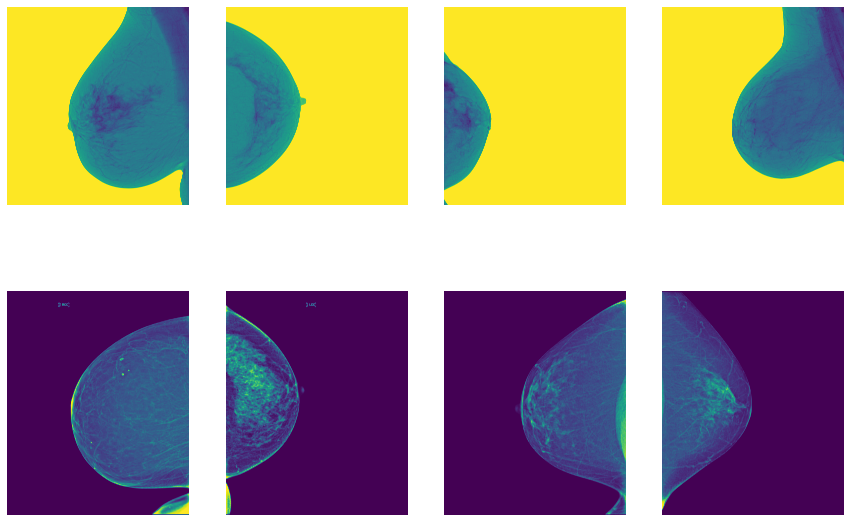

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
axs = axs.flatten()
for i in range(8):
    if i <= 3:
        MONO = 'MONOCHROME1'
    else:
        MONO = 'MONOCHROME2'
    ran = random.randint(0,9000)
    tmp = dicom_df[dicom_df.PhotometricInterpretation == MONO].iloc[ran]
    p_id = tmp.patient_id
    i_id = tmp.image_id
    pas = f'/kaggle/input/rsna-breast-cancer-detection/train_images/{p_id}/{i_id}.dcm'
    im_data = pydicom.dcmread(pas)
    axs[i].imshow(im_data.pixel_array)
    axs[i].axis('off')
plt.show()

In [31]:
!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
import dicomsdl
import numpy as np
import cv2

Processing /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


In [142]:
# patinet_idとimage_idを入れたら処理された画像を返すようにしたい
# 余計な余白と左向き揃えをした画像が出力される
class Image_preproceesor:
    def __init__(self, patient_id, image_id, tra_or_tes='train', side='left'):
        self.image_id = str(image_id)
        self.patient_id = str(patient_id)
        self.side = side
        self.path = "/kaggle/input/rsna-breast-cancer-detection/{}_images/{}/{}.dcm".format(tra_or_tes, self.patient_id, self.image_id)
        print(self.path)
        
    def preprocess(self):
        image = self.read_xray(self.path)
        image = self.crop_image(image)
        print(image.dtype)
        img_side = self.determine_side(image)
        if img_side != self.side: 
            image = cv2.flip(image, 1)
        image = self.img2roi(image)
        return np.array(image)
    
    
    def read_xray(self, path, fix_monochrome = True):
        dicom = dicomsdl.open(path)
        data = dicom.pixelData(storedvalue=False)  # storedvalue = True for int16 return otherwise float32
        data = data - np.min(data)
        data = data / np.max(data)
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = 1.0 - data
        return data

    def crop_image(self, image):
        # 画像によっては不要な枠があるので、取り除く
        image = image[5:-5, 5:-5]
        return image
    
    def img2roi(self, image):
        output= cv2.connectedComponentsWithStats((image > 0.05).astype(np.uint8)[:, :], 8, cv2.CV_32S)
        stats = output[2] # left, top, width, height, area_size

        idx = stats[1:, 4].argmax() + 1
        x1, y1, w, h = stats[idx][:4]
        x2 = x1 + w
        y2 = y1 + h

        image_fit = image[y1: y2, x1: x2]

        return image_fit
    
    def determine_side(self, img, threshold = 0.05):
        """
        img: input image
        threshold: for binirizing image, should be 5
        Side is determined simply by finding more white side of the image.
        """

        if img.dtype == 'float32':
            ret, thresh = cv2.threshold(img, threshold, 1, 0)
#         else:
#             img = (255*img).astype(dtype = 'float32')
#             ret, thresh = cv2.threshold(img, threshold, 1, 0)

        width = img.shape[1]
        # take all columns up to half image (in width), sumarize them and compare with other half
        if sum(sum(thresh[:, :width // 2])) > sum(sum(thresh[:, width // 2:])): 
            return 'left'
        else:
            return 'right'